### Mine PubMed with Jupyter Notebooks


Visualisation and data mining of the public database of biomedical literature PubMed. The mining is performed with a series of queries from a Jupyter Notebook. This started with Matlab Functions in a parallel repository.



#### Reference
Reyes-Aldasoro CC (2017) The proportion of cancer-related entries in PubMed has increased considerably; is cancer truly “The Emperor of All Maladies”? PLoS ONE 12(3): e0173671. https://doi.org/10.1371/journal.pone.0173671

#### Abstract
In this work, the public database of biomedical literature PubMed was mined using queries with combinations of keywords and year restrictions. It was found that the proportion of Cancer-related entries per year in PubMed has risen from around 6% in 1950 to more than 16% in 2016. This increase is not shared by other conditions such as AIDS, Malaria, Tuberculosis, Diabetes, Cardiovascular, Stroke and Infection some of which have, on the contrary, decreased as a proportion of the total entries per year. 

First, import all the things you need to import.

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
import urllib.request

Then you can define the time of study, that is the years that you will be mining the data base. If you (don't) want to visualise which specific year, comment/uncomment the second line 

In [52]:
yearsAnalysis = np.arange(1950,2021)
yearsAnalysis

array([1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960,
       1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020])

Here is where the problem is defined. First we need to define a basic URL. And that will be the address of PubMed with a search term. This give entry to the database MEDLINE of the United States National Library of Medicine (NLM) and its search engine PubMed (https://www.ncbi.nlm.nih.gov/pubmed) have grown to include over 26 million entries: 26,710,394 on the 30 November 2016. 


Then, we will define a series of keywords. In MEDLINE, each entry is indexed with Medical Subject Headings (MeSH) and various field descriptors such as author, date, title, publication type, etc. These fields allow specific searches to be performed in PubMed by restricting the search to one, several or all fields and logical combinations with operators such as AND, OR, NOT are available as well. 

We will apply two separate restrictions, one will be the year, to obtain only items that were published, say in 1968. To instruct PubMed that we are querying the year, we need to specify this with the term [DP] (date publication) and because we will be going through a browser that does not interpret spaces and other symbols we will code like this:



yearURL                             = '%22'+str(1968)+'%22%5BDP%5D+';

Then we add the actual keywords related to the actual conditions that we want to observe. Let's do this for: ** Cancer, AIDS, Malaria, Cardiovascular, Tuberculosis, Stroke, Diabetes ** and ** Infection**.

In [53]:
# 0
#Basic keywords that describe cancer, concatenate
basicURL                = 'https://www.ncbi.nlm.nih.gov/pubmed/?term='
allF                    = '%5BAll%20Fields%5D' # all fields code

CancerKeyW_1            =  '(%22neoplasms%22';
CancerKeyW_2            =  'OR%22cancer%22';
CancerKeyW_3            =  'OR%22tumor%22';
CancerKeyW_4            =  'OR%22tumour%22';
CancerKeyW_5            =  'OR%22oncology%22'+allF+')';
CancerKeywords          =  CancerKeyW_1+CancerKeyW_2+CancerKeyW_3+CancerKeyW_4+CancerKeyW_5

# 1 Aids keywords
AIDSKeyW_6              =  '(%22acquired%20immunodeficiency%20syndrome%22%5BMeSH%20Terms%5D%20';
AIDSKeyW_7              =  'OR%20(%22acquired%22%5BAll%20Fields%5D%20AND%20%22immunodeficiency%22%5BAll%20Fields%5D%20AND%20%22syndrome%22%5BAll%20Fields%5D)%20';
AIDSKeyW_8              =  'OR%20%22acquired%20immunodeficiency%20syndrome%22%5BAll%20Fields%5D%20';
AIDSKeyW_9              =  'OR%20%22aids%22%5BAll%20Fields%5D)';
AIDSKeywords            = AIDSKeyW_6+AIDSKeyW_7+AIDSKeyW_8+AIDSKeyW_9

# 2 Run the same per year analysis for Malaria 
MalariaKeywords         =  'AND%20%22malaria%22%5BAll%20Fields%5D';

# 3 Cardiovascular
CardioKeywords          =  'AND%20%22cardiovascular%22%5BAll%20Fields%5D';

# 4 Tuberculosis
TuberculosisKeywords    =  'AND%20%22tuberculosis%22%5BAll%20Fields%5D';

# 5 stroke
strokeKeywords          =  'AND%20%22stroke%22%5BAll%20Fields%5D';

# 6 Diabetes
DiabetesKeywords        =  'AND%20%22diabetes%22%5BAll%20Fields%5D';

# 7 infection
infectionKeywords       =  'AND%20%22infection%22%5BAll%20Fields%5D';

# 8 all cases
generalKeywords         = '';

Notice the last keyword, which is actually blank. This is because we want also to retrieve all entries of a given year. Next, we concatenate all the keywords into a vector (or matrix, or whichever name is the correct in Python).

In [54]:
keywords=[CancerKeywords,AIDSKeywords,MalariaKeywords,CardioKeywords,TuberculosisKeywords,strokeKeywords,DiabetesKeywords,infectionKeywords,generalKeywords]


We initialise a matrix (idem about naming) where we will record the entries of each condition per year.

In [55]:
EntriesPerDisease = np.zeros((len(keywords),len(yearsAnalysis))) # disease (and total) and year


Now we iterate. To find the actual number of entries, we look for the word **resultcount** and grab the number that is in between  **=** and **/**.

In [58]:
# iterate over the years and the keywords
#for x in keywords:
for i in range(len(yearsAnalysis)):
    # Define the basic link that are going to be read from pubmed
    # add the search term (i.e. ? term) and the delimiters 
    #    %27  correspond to ' and %22 corespond to "
    # link = 'https://pubmed.ncbi.nlm.nih.gov/?term=%27'+x+'%27'
    
    year                                = yearsAnalysis[i];
    
    
    
    print(year)
    #yearURL                             = 'AND+%22'+str(year)+'%22%5BDP%5D+';
    yearURL                             = '%22'+str(year)+'%22%5BDP%5D+';
    for j in range(len(keywords)):
        # This is the code to select PubMed entries combined with year
        #urlAddress                          = basicURL+yearURL+keywords[j]+'%27'+allF
        urlAddress                          = basicURL+yearURL+keywords[j]
         
        # If you want to see the actual url that will be queried, 
        # uncomment the following line
        #print(urlAddress)
        
        # read from the link, it is important to use the try as
        # sometimes there are time outs,
        try: 
            with urllib.request.urlopen(urlAddress) as url:
               #f = urllib.request.urlopen.read(link)
              wholeURL = url.read().decode('utf-8')
            # Once the wholeURL is downloaded, search for the place where the total
            # number of entries in PubMed exist, this can be done with 2 codes, 
            # one is totalResults and the other is resultcount. This changed recently with 
            # the new page results from PubMed

            # find the code
            location_init = wholeURL.index('resultcount')
            # detect the limits of the result number itself, use = and / to limit
            location_2    = wholeURL.find('=',location_init,location_init+30)
            location_3    = wholeURL.find('/',location_2+1,location_2+30)
            # the actual number of entries
    
            EntriesPerDisease[j,i] = wholeURL[location_2+2:location_3-2]
        except:
            EntriesPerDisease[j,i] = 0
            

1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


You can remove the years by commenting the line 

 print(year).
 
But when processes take long, sometimes it is useful to know the progress. Similarly, you can uncomment the lines below to find out the url address, the whole url (i.e. the webpage reported by PubMed) and the number of entries of a given year.

In [59]:
 # wholeURL[location_2+2:location_3-2]  #this is the number of publications per year with keyword

In [60]:
# urlAddress  #actual URL that is going to be queried

In [61]:
# wholeURL # this is the whole URL (rather large...)

Once the iteration has finished, what is interesting is to display the numbers as a graph. This is the raw numbers, i.e. absolute values of each query.

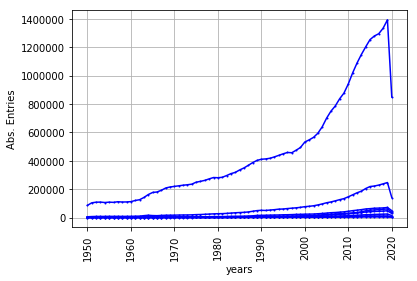

In [91]:
# Display the absolute number of entries, 
fig = mpl.figure()
ax = fig.add_subplot(111)

mpl.plot(EntriesPerDisease.T, linestyle='-', marker='.', color='b',markersize = 2)
#mpl.xlabel(keywords)
mpl.xlabel('years')
mpl.ylabel('Abs. Entries')
#ax.xaxis.set_ticks([0,70,10])
#ax.xaxis.set_ticklabels(keywords)
tickValues =np.arange(1940,2021,10)
ax.xaxis.set_ticklabels((tickValues))
ax.tick_params(axis='x', rotation=90)
mpl.grid()

What we can see of this graph is that there is a constant growth of all cases, except for the last point, but since I am running this in July 2020, this will only include the entries of half of the year. 

More interesting than these absolute numbers are the relative ones, i.e. * how many entries of 1950 correspond to AIDS, Malaria, etc.*

Let's divide each case per the total:

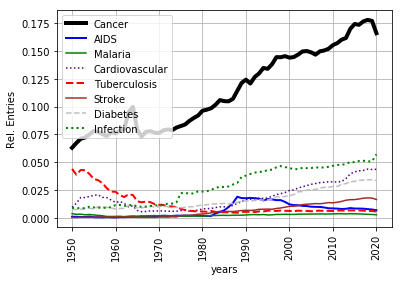

In [114]:
# Display all entries as a proportion of the total number of entries of the year

fig = mpl.figure()
ax = fig.add_subplot(111)
mpl.plot(yearsAnalysis,EntriesPerDisease[0,:]/EntriesPerDisease[8,:],label="Cancer", linestyle='-',linewidth=4,   marker='', color='k',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[1,:]/EntriesPerDisease[8,:],label="AIDS", linestyle='-',linewidth=2,  marker='', color='b',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[2,:]/EntriesPerDisease[8,:],label="Malaria",  linestyle='-', marker='', color='g',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[3,:]/EntriesPerDisease[8,:],label="Cardiovascular",  linestyle=':', marker='', color='indigo',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[4,:]/EntriesPerDisease[8,:],label="Tuberculosis",  linestyle='--',linewidth=2,  marker='', color='r',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[5,:]/EntriesPerDisease[8,:],label="Stroke",  linestyle='-', marker='', color='brown',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[6,:]/EntriesPerDisease[8,:],label="Diabetes",  linestyle='--', marker='', color='0.75',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[7,:]/EntriesPerDisease[8,:],label="Infection",  linestyle=':',linewidth=2,  marker='', color='g',markersize = 5)


ax.xaxis.set_ticklabels((tickValues))
mpl.xlabel('years')
mpl.ylabel('Rel. Entries')
#ax.xaxis.set_ticks([0,70,10])
#ax.xaxis.set_ticklabels(keywords)
tickValues =np.arange(1940,2021,10)
ax.xaxis.set_ticklabels((tickValues))
ax.tick_params(axis='x', rotation=90)
mpl.legend(loc="upper left")
mpl.grid()


Here is where things start getting interesting. **Cancer** has been steadily growing from around 6% to around 17.5%. This is as a proportion of all entries. Imagine **all** the medical publications indexed by PubMed in 2019, nearly 1 in 5 is related to cancer. To appreciate the other conditions, let's display again but without cancer.

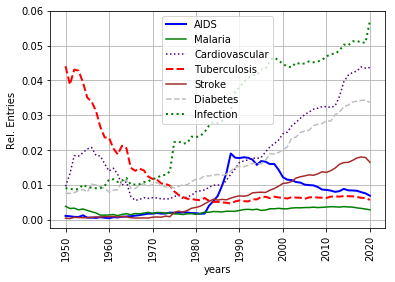

In [115]:
# Repeat but remove cancer
fig = mpl.figure()
ax = fig.add_subplot(111)
mpl.plot(yearsAnalysis,EntriesPerDisease[1,:]/EntriesPerDisease[8,:],label="AIDS", linestyle='-',linewidth=2,  marker='', color='b',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[2,:]/EntriesPerDisease[8,:],label="Malaria",  linestyle='-', marker='', color='g',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[3,:]/EntriesPerDisease[8,:],label="Cardiovascular",  linestyle=':', marker='', color='indigo',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[4,:]/EntriesPerDisease[8,:],label="Tuberculosis",  linestyle='--',linewidth=2,  marker='', color='r',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[5,:]/EntriesPerDisease[8,:],label="Stroke",  linestyle='-', marker='', color='brown',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[6,:]/EntriesPerDisease[8,:],label="Diabetes",  linestyle='--', marker='', color='0.75',markersize = 5)
mpl.plot(yearsAnalysis,EntriesPerDisease[7,:]/EntriesPerDisease[8,:],label="Infection",  linestyle=':',linewidth=2,  marker='', color='g',markersize = 5)

ax.xaxis.set_ticklabels((tickValues))
mpl.xlabel('years')
mpl.ylabel('Rel. Entries')

tickValues =np.arange(1940,2021,10)
ax.xaxis.set_ticklabels((tickValues))
ax.tick_params(axis='x', rotation=90)
mpl.legend(loc="upper center")
mpl.grid()

Tuberculosis goes down, Infection goes up, Malaria stays low.

AIDS is an interesting case. It has a rise climb in the mid 80s, then stabilises, then drops. The peak in the late 1980s is close to the development of anti-retroviral treatments like zidovudine and their approval, as a therapy against HIV, by the US Food and Drug Administration (FDA) in 1987. The entries remained relatively constant until the late 1990s (more or less when the effective number of infections plateaus in the US) and after that date there has been a steady decline in the number of entries, but not of global deaths. The paper analyses this and other trends with more detail.




